# Building and Training a Feed Forward Neural Network in PyTorch

In this notebook, we’ll build a simple neural network using PyTorch, train it on the SNOTEL dataset, and evaluate its performance. This hands-on exercise will reinforce our understanding of the PyTorch framework and the steps involved in building and training neural networks on real-world data.

## Load Libraries


In [14]:
%pip install -q torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

available_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Available device: {available_device}")

Available device: cpu


## Preparing the Dataset

### Step 1: Load Dataset

We'll start by loading the SNOTEL dataset from a CSV file.

In [16]:
snotel_data=pd.read_csv("data/clean_data.csv")
snotel_data.info()
snotel_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2469 entries, 0 to 2468
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   swe                 2469 non-null   float64
 1   snowdepth           2469 non-null   float64
 2   tempavg_7_days_avg  2469 non-null   float64
 3   precip_7_days_avg   2469 non-null   float64
 4   snowdensity         2469 non-null   float64
dtypes: float64(5)
memory usage: 96.6 KB


,swe,snowdepth,tempavg_7_days_avg,precip_7_days_avg,snowdensity
0,27.178,91.44,-1.414286,0.653143,0.297222
1,27.686,91.44,-1.528571,0.544286,0.302778
2,27.686,91.44,-0.971429,0.435429,0.302778
3,27.686,88.90,-0.557143,0.399143,0.311429
4,27.686,88.90,-0.271429,0.181429,0.311429


### Step 2: Data Split

We’ll split the data into training, validation, and testing sets. Typically, a common split might be 70% training, 15% validation, and 15% testing.

In [17]:
features = snotel_data.drop('snowdensity', axis=1).values
targets = snotel_data['snowdensity'].values

# Split the dataset into training and temp sets (85% train, 15% temp)
features_train, features_temp, targets_train, targets_temp = train_test_split(
    features, targets, test_size=0.3, random_state=0
)

# Further split the temp set into validation and test sets (15% each)
features_val, features_test, targets_val, targets_test = train_test_split(
    features_temp, targets_temp, test_size=0.5, random_state=0
)

### Step 3: Preprocess Data

Now that we've split the data, we can apply scaling. The scaler should be fit on the training data and then used to transform the training, validation, and test sets.

In [18]:
scaler = StandardScaler()

scaler.fit(features_train)

# Transform the training, validation, and test sets
features_train = scaler.transform(features_train)
features_val = scaler.transform(features_val)
features_test = scaler.transform(features_test)

### Step 4: Creating Custom Datasets

Next, we define custom `Dataset` classes for each of the three sets: training, validation, and testing.

In [19]:
class SNOTELDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Create instances of the custom datasets for training, validation, and testing sets
train_dataset = SNOTELDataset(data=features_train, targets=targets_train)
val_dataset = SNOTELDataset(data=features_val, targets=targets_val)
test_dataset = SNOTELDataset(data=features_test, targets=targets_test)


### Step 5: Using DataLoader

Now, we use `DataLoader` to manage our data in mini-batches during training, validation, and testing.

In [20]:
# Create DataLoaders for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Defining the Neural Network

We define a simple feedforward neural network using `torch.nn.Module`.

In [21]:
class SNOTELNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SNOTELNN, self).__init__() # super class to inherit from nn.Module
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.relu = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Fully connected layer 2
    
    def forward(self, x): # x is the batch of input
        # Define the forward pass
        out = self.fc1(x)  # Pass input through first layer
        out = self.relu(out)  # Apply ReLU activation
        out = self.fc2(out)  # Pass through second layer to get output
        return out

# Instantiate the model
# Instantiate the model and move it to the device (GPU or CPU)
model = SNOTELNN(input_size=features_train.shape[1], hidden_size=128, output_size=1).to(available_device)

The `forward` method defines how the input data flows through the network layers. It specifies the sequence of operations that the data undergoes as it moves from the input layer to the output layer. This method is automatically called when you pass data through the model (e.g., `outputs = model(inputs)`).

## Setting the Loss Function and Optimizer

For this example, we’ll use Mean Squared Error Loss since we’re dealing with a regression problem. We’ll use the Adam optimizer, which is a good default choice due to its adaptive learning rates.

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Training the Network

We now write the training loop, which includes zeroing the gradients, performing the forward pass, computing the loss, backpropagating, and updating the model parameters. We will also validate the model on the validation set after each epoch.

```{note}
An **Epoch** refers to one complete pass through the entire training dataset. During each epoch, the model sees every example in the dataset once.
```

In [23]:
num_epochs = 5

# Lists to store the training and validation losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0  # Initialize cumulative training loss
    
    for inputs, labels in train_loader:
        # Move data to the appropriate device
        inputs, labels = inputs.to(available_device), labels.to(available_device)
        
        # Zero the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Perform backward pass (compute gradients)
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        
        # Accumulate training loss
        train_loss += loss.item()
    
    # Average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Store the training loss for this epoch
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(available_device), labels.to(available_device)  # Move to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)  # Store the validation loss for this epoch
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch [1/5], Training Loss: 0.1605, Validation Loss: 0.1082
Epoch [2/5], Training Loss: 0.0854, Validation Loss: 0.0584
Epoch [3/5], Training Loss: 0.0465, Validation Loss: 0.0314
Epoch [4/5], Training Loss: 0.0256, Validation Loss: 0.0172
Epoch [5/5], Training Loss: 0.0148, Validation Loss: 0.0103


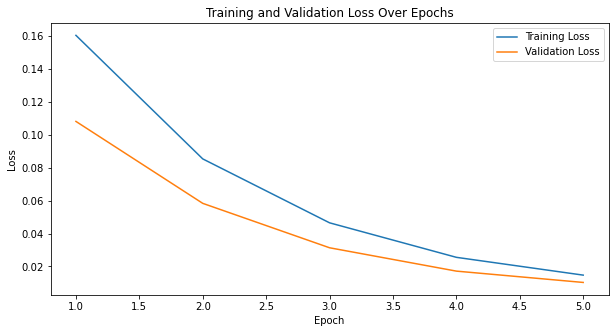

In [24]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Testing the Model

Test Loss: 0.0094


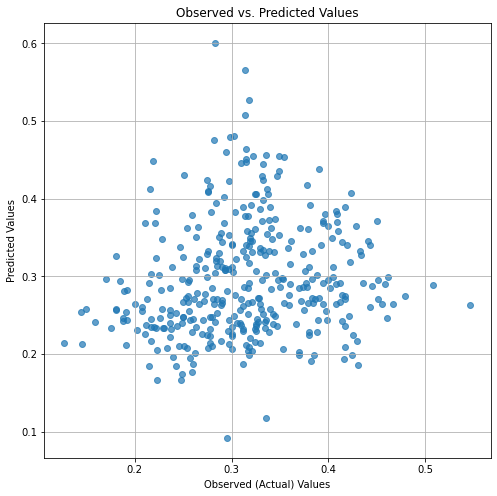

In [25]:
# Evaluate the model on the test set and collect predictions
model.eval()  # Set the model to evaluation mode
test_loss = 0.0  # Initialize cumulative test loss
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in test_loader:
        # Move data to the appropriate device
        inputs, labels = inputs.to(available_device), labels.to(available_device)
        
        # Perform forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Accumulate test loss
        test_loss += loss.item()
        
        # Store the predictions and the corresponding labels
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the average test loss
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Convert lists to numpy arrays for plotting
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Plot observed vs predicted
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.7)
plt.xlabel('Observed (Actual) Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs. Predicted Values')
plt.grid(True)
plt.show()


## Saving the Model

Saving your trained model is an essential part of any machine learning project. It allows you to reuse the model for predictions, further training, or sharing with others without having to retrain it from scratch. In PyTorch, saving and loading models is straightforward and can be done using the `torch.save` and `torch.load` functions. 

In [26]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'snotel_nn_model.pth')


# Initialize the model architecture
model = SNOTELNN(input_size=features_train.shape[1], hidden_size=128, output_size=1)

# Load the model's state dictionary
model.load_state_dict(torch.load('snotel_nn_model.pth', weights_only=True))

# Set the model to evaluation mode before inference
model.eval()

SNOTELNN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

## Hyperparameter Tuning

Hyperparameter tuning is a critical step in building machine learning models. Unlike model parameters (like weights and biases), which are learned from the data during training, hyperparameters are the settings you choose before the training process begins. These include:

- **Learning Rate**: Controls how much to adjust the model’s weights with respect to the loss gradient.
- **Batch Size**: Determines the number of training examples utilized in one iteration.
- **Number of Hidden Layers and Neurons**: Specifies the architecture of the neural network.
- **Optimizer**: The algorithm used to update model weights based on the computed gradients (e.g., Adam, SGD).


Tuning these hyperparameters can significantly affect the performance of your model. However, finding the optimal set of hyperparameters can be a challenging and time-consuming process, often requiring experimentation.

### Manual vs. Automated Tuning

- **Manual Tuning**: Involves adjusting hyperparameters based on intuition, experience, or trial and error. While straightforward, this approach can be inefficient and might not always yield the best results.
- **Automated Tuning**: Tools like **Optuna** can help automate the search for the best hyperparameters. These tools explore the hyperparameter space more systematically and can save a lot of time compared to manual tuning. Sample PyTorch hyperparameter tuning for Optuna can be found [here](https://github.com/optuna/optuna-examples/tree/main/pytorch).

### Further Reading and Tools

Since hyperparameter tuning is a vast topic and we have limited time, I recommend exploring the following resources and tools for a deeper dive

* Optuna: [documentation](https://optuna.org/)
* Ray Tune:  A scalable hyperparameter tuning library, particularly useful if you need to distribute tuning across multiple machines. See [documentation](https://docs.ray.io/en/latest/tune/index.html) for more.

## Acknowledgements

* Many thanks to HP Marshall (my advisor) for his mentorship and support. 
* Many thanks to e-Science institute and all organizing members for allowing me deploy/present this tutorial. A huge thanks to eveyone for listening.

## Reference

1. [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
2. [Machine Learning Bookcamp](https://www.manning.com/books/machine-learning-bookcamp?query=machine)
3. [An Introduction to Statistical Learning with Applications in R](https://link.springer.com/book/10.1007%2F978-1-4614-7138-7) (available online for free)
4. [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)
[Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning)